In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aicc

In [7]:
#load data
df = pd.read_excel('3Data.xls', parse_dates=['Date'], index_col='Date')
print(df.shape)  # (290, 3)
df.tail()

(290, 3)


,CPI,GSCPI,UNRATE
Date,,,
2023-10-01,4.02170,-0.379260,3.8
2023-11-01,4.01509,0.155375,3.7
2023-12-01,3.91012,-0.156193,3.7
2024-01-01,3.87468,-0.231482,3.7
2024-02-01,3.76195,0.100508,3.9


In [ ]:
# grangers casuality test
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):

    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)
#CPI_ GSCPI_y	0.2888	UNRATE_y	0.0384

In [10]:
# forecasting months
nobs = 30
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (260, 3)
print(df_test.shape)  # (30, 3)

(260, 3)
(30, 3)


In [11]:
#build the adfuller test
def ADF_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue']
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")

In [12]:
# ADF Test
for name, column in df_train.iteritems():
    ADF_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.2426
 No. Lags Chosen       = 13
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.1911. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "GSCPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2486
 No. Lags Chosen       = 7
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.9325. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "UNRATE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit

<ipython-input-12-1e55b7dd4de1>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_train.iteritems():


In [13]:
# 1st difference
df_differenced = df_train.diff().dropna()

In [15]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    ADF_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -5.1874
 No. Lags Chosen       = 12
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GSCPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -8.8067
 No. Lags Chosen       = 6
 Critical value 1%     = -3.457
 Critical value 5%     = -2.873
 Critical value 10%    = -2.573
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "UNRATE" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.

<ipython-input-15-c2b813fc650a>:2: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, column in df_differenced.iteritems():


In [16]:
# AIC test
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9,10]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)

Lag Order = 1
AIC :  -6.609094253253042
Lag Order = 2
AIC :  -6.627294978813094
Lag Order = 3
AIC :  -6.657778852197325
Lag Order = 4
AIC :  -6.698414691353547
Lag Order = 5
AIC :  -6.701139567188953
Lag Order = 6
AIC :  -6.710587179473728
Lag Order = 7
AIC :  -6.662454163168451
Lag Order = 8
AIC :  -6.696319880632644
Lag Order = 9
AIC :  -6.724104535891131
Lag Order = 10
AIC :  -6.72147179515235


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [17]:
# Order selection with select_order
x = model.select_order(maxlags=10)
x.summary()

,AIC,BIC,FPE,HQIC
0,-6.328,-6.285,0.001786,-6.311
1,-6.575,-6.405*,0.001395,-6.507*
2,-6.592,-6.296,0.001371,-6.473
3,-6.616,-6.192,0.001339,-6.446
4,-6.659,-6.108,0.001283,-6.437
5,-6.664,-5.985,0.001277,-6.391
6,-6.679,-5.874,0.001258,-6.355
7,-6.643,-5.711,0.001305,-6.268
8,-6.684,-5.624,0.001253,-6.257
9,-6.713,-5.526,0.001218,-6.235


In [19]:
model_fitted = model.fit(10)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 18, Mar, 2024
Time:                     13:43:02
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -5.40772
Nobs:                     249.000    HQIC:                  -6.19267
Log likelihood:          -130.124    FPE:                 0.00120947
AIC:                     -6.72147    Det(Omega_mle):     0.000850585
--------------------------------------------------------------------
Results for equation CPI
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.005373         0.008620            0.623           0.533
L1.CPI             0.421195         0.069767            6.037           0.000
L1.GSCPI          -0.010534         0.027324           -0.386           0.

In [20]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print((col), ':', round(val, 2))

CPI : 2.05
GSCPI : 2.0
UNRATE : 1.98


In [21]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

10


array([[ 0.03751   ,  0.63209654, -0.1       ],
       [-0.04017   ,  0.92058509,  0.        ],
       [-0.2276    , -0.35449864, -0.3       ],
       [-0.12073   ,  0.61396538, -0.2       ],
       [ 0.36929   ,  0.31273237, -0.1       ],
       [ 1.31564   ,  0.51364063,  0.        ],
       [ 0.81892   ,  0.26603994, -0.3       ],
       [ 0.639     , -0.2689753 ,  0.1       ],
       [-0.21497   ,  0.17457023, -0.5       ],
       [-0.2529    ,  0.34859487, -0.3       ]])

In [22]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_d')
df_forecast

,CPI_d,GSCPI_d,UNRATE_d
Date,,,
2021-09-01,-0.219230,-0.250166,1.144028
2021-10-01,-0.162699,-0.656661,0.706426
2021-11-01,-0.016880,-0.016817,0.386437
2021-12-01,0.215744,0.174524,0.614713
2022-01-01,0.227070,0.072773,0.471714
2022-02-01,-0.023956,0.073446,0.562353
2022-03-01,-0.232355,-0.235511,-0.008961
2022-04-01,-0.390266,-0.205146,-0.431289
2022-05-01,-0.143940,0.061649,-0.340080


In [23]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_d'].cumsum()
    return df_fc

In [27]:
df_results = invert_transformation(df_train, df_forecast, second_diff=False)
df_results.loc[:, ['CPI_forecast', 'GSCPI_forecast', 'UNRATE_forecast']]

,CPI_forecast,GSCPI_forecast,UNRATE_forecast
Date,,,
2021-09-01,3.731360,3.007883,6.244028
2021-10-01,3.568661,2.351222,6.950454
2021-11-01,3.551781,2.334405,7.336890
2021-12-01,3.767525,2.508929,7.951603
2022-01-01,3.994595,2.581702,8.423317
2022-02-01,3.970639,2.655149,8.985670
2022-03-01,3.738284,2.419638,8.976709
2022-04-01,3.348019,2.214492,8.545420
2022-05-01,3.204079,2.276141,8.205341


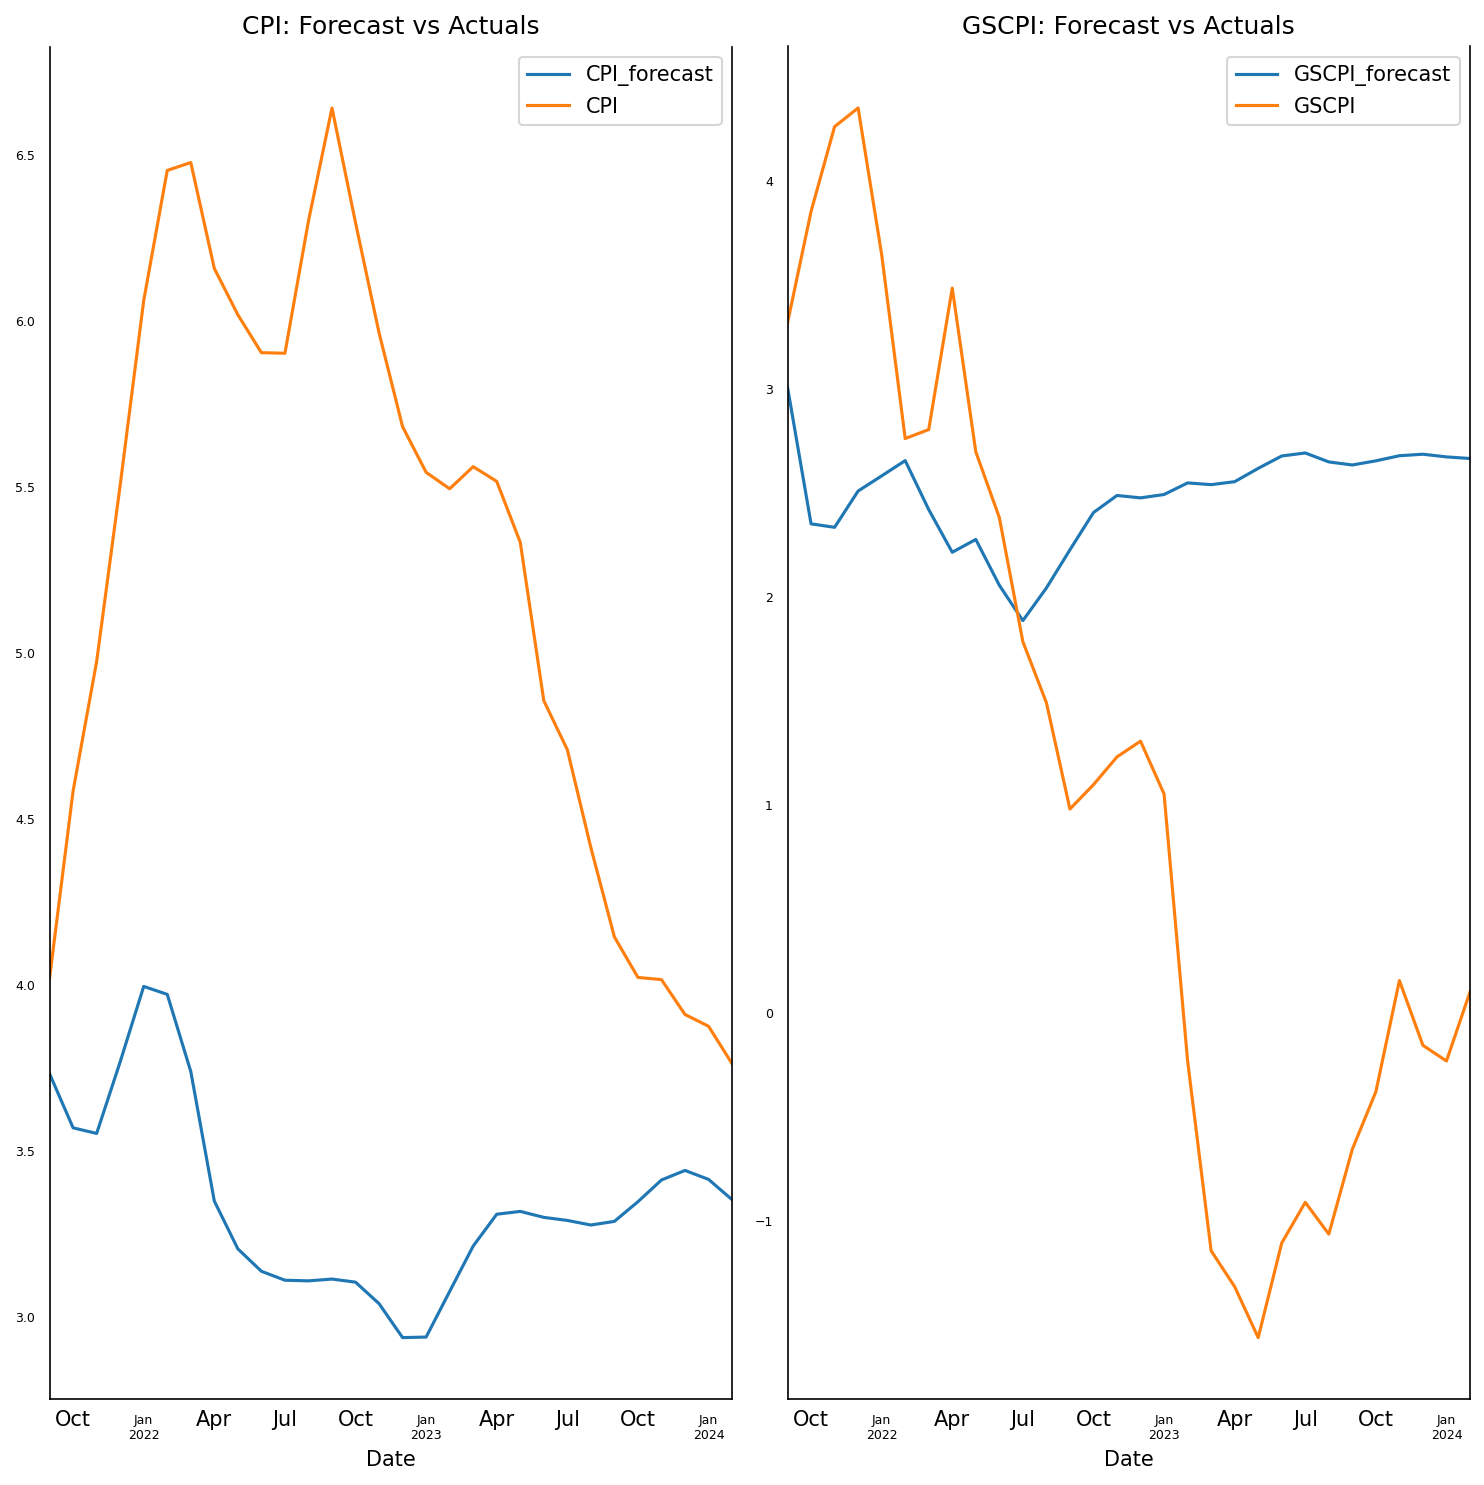

In [28]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [31]:
#evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error


rmse = np.sqrt(mean_squared_error(df_test['CPI'],df_results['CPI_forecast'].values))
print('Root Mean Square Error value of the VAR Model is:', (1-rmse)*100)

mape = np.mean(np.abs((df_test['CPI']-df_results['CPI_forecast'].values)/df_test['CPI']))*100
print('Mean Absolute Percentage Error value of the VAR Model is:', (mape))

mpe = np.mean(df_test['CPI']-df_results['CPI_forecast'].values)
print('Mean percentage Error value of the VAR Model is:', (mpe))

Root Mean Square Error value of the VAR Model is: -115.38836249074018
Mean Absolute Percentage Error value of the VAR Model is: 34.29784943726155
Mean percentage Error value of the VAR Model is: 1.9228963191257853
